# Abstract

This notebook reproduces the Langevian sampling on celeba dataset

Source of pretrained GAN: https://github.com/joeylitalien/celeba-gan-pytorch/tree/master

In [1]:
import os

import numpy as np
from tqdm import tqdm

import torch
import torch.nn as nn
import torch.nn.parallel
from torch.distributions import MultivariateNormal, Normal, Independent, Uniform

import torchvision

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
import sys
sys.path.append('...')

from celeba_data.generator_class import Generator, Discriminator

In [3]:
if torch.cuda.is_available():
    device = "cuda"
elif torch.backends.mps.is_available():
    device = "mps"
else:
    device = "cpu"

# Models

In [4]:
model_gen = Generator()
model_gen.load_state_dict(torch.load('celeba_data/gan-gen.pt', map_location=device))
model_gen.to(device).eval()

model_disc = Discriminator()
model_disc.load_state_dict(torch.load('celeba_data/gan-disc.pt', map_location=device))
model_disc.to(device).eval()

Discriminator(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (6): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (9): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.2, inplace=True)
    (11): Conv2d(512, 1, kernel_size=(4, 4), stride=(1, 1))
    (12): Sigmoid()
  )
)

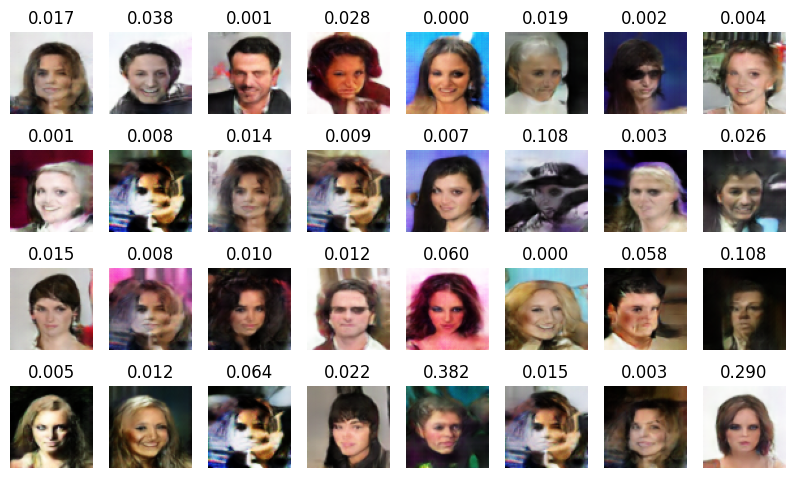

In [5]:
batch_size=32
n_dims = 100

plt.figure(figsize=[10,12])
noize=torch.randn(batch_size, n_dims)

samples=model_gen(noize.to(device))
samples=samples*0.5+0.5
score=model_disc(model_gen(noize.to(device)))

for i in range(batch_size):
    plt.subplot(8,8,i+1)
    plt.axis('off')
    plt.title(f"{score[i].cpu().detach().numpy():.3f}")
    plt.imshow(samples[i].permute(1,2,0).cpu().detach().numpy())

# FID
Now compute Frechet Inception distance - a metric for GANs

In [6]:
from torcheval.metrics import FrechetInceptionDistance
import torchvision.transforms as transforms


transform = transforms.Compose(
    [transforms.ToTensor()]) 

trainset = torchvision.datasets.CIFAR10(root='./cifar10_data/data', train=True,
                                        download=True, transform=transform)

trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True)

real = next(iter(trainloader))[0]
fake = samples.to('cpu')

fid = FrechetInceptionDistance()

fid.update(real, True)
fid.update(fake, False)
fid.compute()

Files already downloaded and verified


tensor(323.0603)

# Energy sampling

In [7]:
def langevin_sampling(N, z_dim, generator, discriminator, device, eps=1e-3):
    eps = torch.tensor([eps]).to(device)
    # Create normal distribution
    loc = torch.zeros(z_dim).to(device)
    scale = torch.ones(z_dim).to(device)
    normal = Normal(loc, scale)
    # Making it independent
    diagn = Independent(normal, 1)
    # init noise
    z = diagn.sample()
    # Begin iterations
    for i in range(N):
        z.requires_grad = True
        n = normal.sample()
        # compute energy function
        log_p = diagn.log_prob(z)
        d = discriminator(generator(z.view(1, z.size()[0])))
        d = torch.log(d / (1 - d))
        energy = -log_p - d
        # gradient
        energy.backward()
        # get new point
        with torch.no_grad():
            z = z - eps / 2 * z.grad + torch.sqrt(eps) * n
    return z

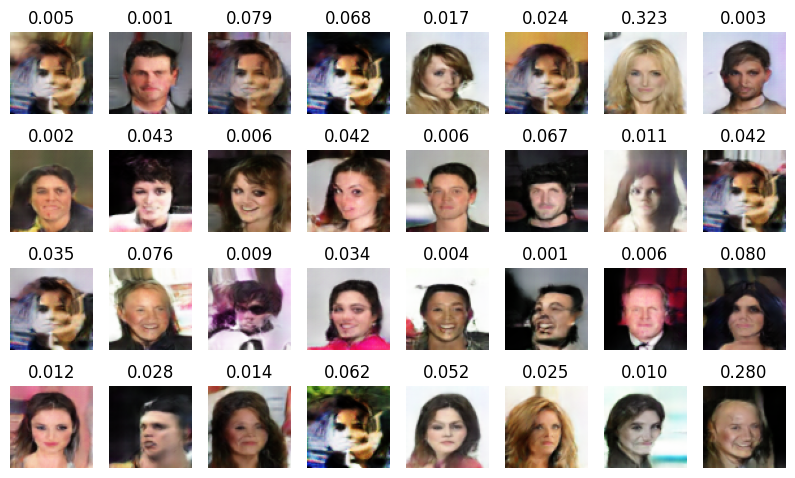

In [8]:
batch_size=32
n_dims = 100

N = 10
eps=1e-3

plt.figure(figsize=[10,12])

noize=[]
for i in range(batch_size):
    noize.append(langevin_sampling(N, n_dims, model_gen, model_disc, device, eps=eps).to('cpu'))
noize = torch.tensor(np.array(noize))

samples=model_gen(noize.to(device))
samples=samples*0.5+0.5
score=model_disc(model_gen(noize.to(device)))

for i in range(batch_size):
    plt.subplot(8,8,i+1)
    plt.axis('off')
    plt.title(f"{score[i].cpu().detach().numpy():.3f}")
    plt.imshow(samples[i].permute(1,2,0).cpu().detach().numpy())

In [9]:
real = next(iter(trainloader))[0]
fake = samples.to('cpu')

fid = FrechetInceptionDistance()

fid.update(real, True)
fid.update(fake, False)
fid.compute()

tensor(285.1955)

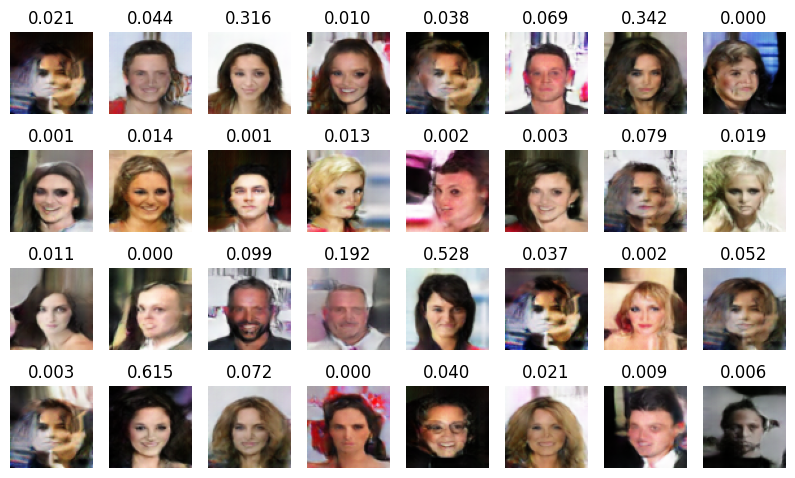

In [10]:
batch_size=32
n_dims = 100

N = 10
eps=1e-5

plt.figure(figsize=[10,12])

noize=[]
for i in range(batch_size):
    noize.append(langevin_sampling(N, n_dims, model_gen, model_disc, device, eps=eps).to('cpu'))
noize = torch.tensor(np.array(noize))

samples=model_gen(noize.to(device))
samples=samples*0.5+0.5
score=model_disc(model_gen(noize.to(device)))

for i in range(batch_size):
    plt.subplot(8,8,i+1)
    plt.axis('off')
    plt.title(f"{score[i].cpu().detach().numpy():.3f}")
    plt.imshow(samples[i].permute(1,2,0).cpu().detach().numpy())

In [11]:
real = next(iter(trainloader))[0]
fake = samples.to('cpu')

fid = FrechetInceptionDistance()

fid.update(real, True)
fid.update(fake, False)
fid.compute()

tensor(311.4500)

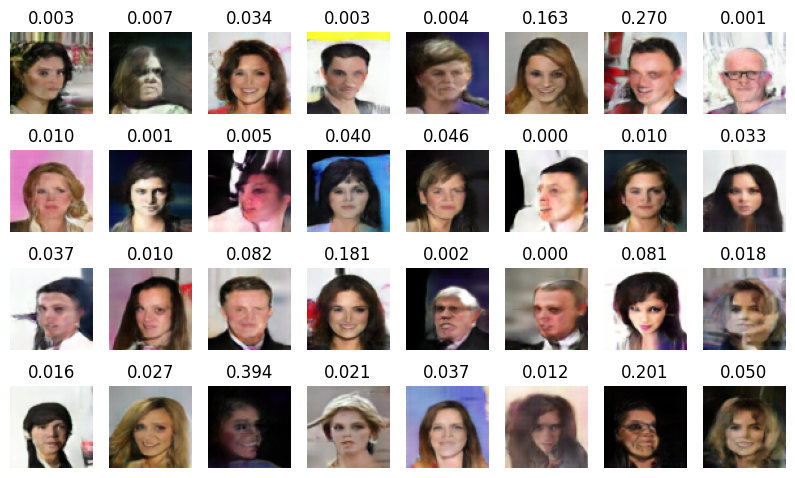

In [12]:
batch_size=32
n_dims = 100

N = 10
eps=1e-7

plt.figure(figsize=[10,12])

noize=[]
for i in range(batch_size):
    noize.append(langevin_sampling(N, n_dims, model_gen, model_disc, device, eps=eps).to('cpu'))
noize = torch.tensor(np.array(noize))

samples=model_gen(noize.to(device))
samples=samples*0.5+0.5
score=model_disc(model_gen(noize.to(device)))

for i in range(batch_size):
    plt.subplot(8,8,i+1)
    plt.axis('off')
    plt.title(f"{score[i].cpu().detach().numpy():.3f}")
    plt.imshow(samples[i].permute(1,2,0).cpu().detach().numpy()) # 00:43<00:00,  1.35s/it

In [13]:
real = next(iter(trainloader))[0]
fake = samples.to('cpu')

fid = FrechetInceptionDistance()

fid.update(real, True)
fid.update(fake, False)
fid.compute()

tensor(299.6105)

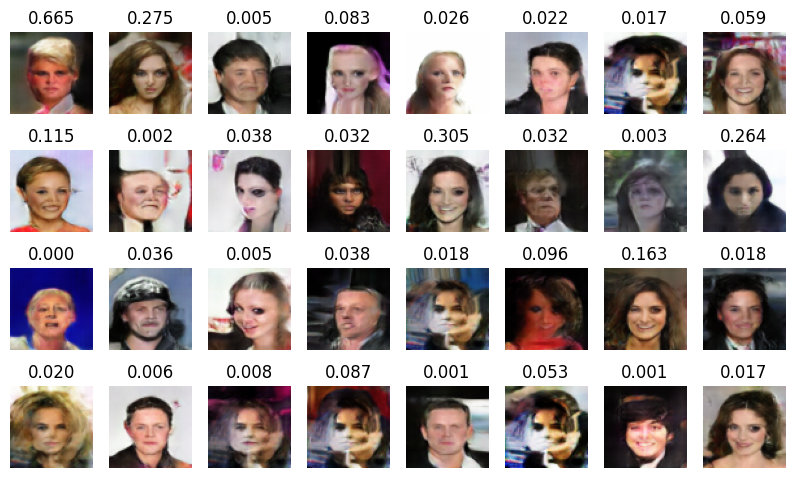

In [14]:
batch_size=32
n_dims = 100

N = 10
eps=1e-7

plt.figure(figsize=[10,12])

noize=[]
for i in range(batch_size):
    noize.append(langevin_sampling(N, n_dims, model_gen, model_disc, device, eps=eps).to('cpu'))
noize = torch.tensor(np.array(noize))

samples=model_gen(noize.to(device))
samples=samples*0.5+0.5
score=model_disc(model_gen(noize.to(device)))

for i in range(batch_size):
    plt.subplot(8,8,i+1)
    plt.axis('off')
    plt.title(f"{score[i].cpu().detach().numpy():.3f}")
    plt.imshow(samples[i].permute(1,2,0).cpu().detach().numpy()) # 00:43<00:00,  1.35s/it

In [15]:
real = next(iter(trainloader))[0]
fake = samples.to('cpu')

fid = FrechetInceptionDistance()

fid.update(real, True)
fid.update(fake, False)
fid.compute()

tensor(311.1375)

# Alternative computation

! working


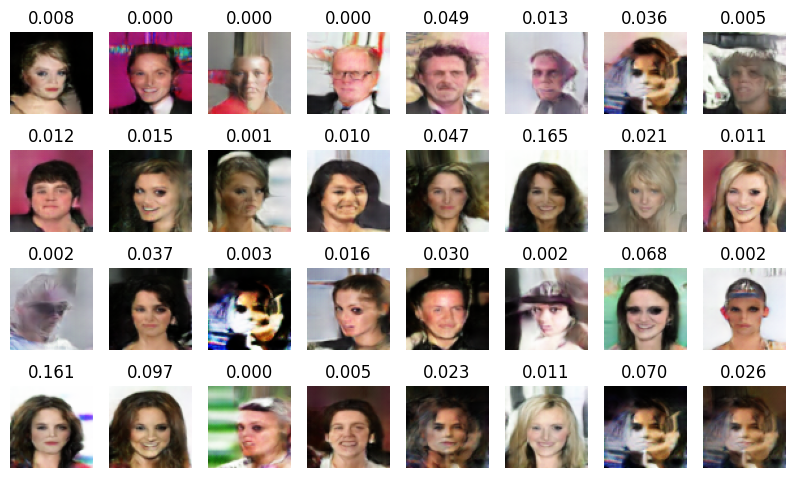

In [16]:
def Score_greadient(z, gen, disc):
    z_new=z.clone().requires_grad_(True)
    score_z_new=disc(gen(z_new.to(device)))
    gradients = torch.autograd.grad(outputs=score_z_new, 
                                    inputs=z_new,
                                    grad_outputs=torch.ones_like(score_z_new),
                                    create_graph=False, 
                                    retain_graph=False, 
                                    only_inputs=True)[0]
    return gradients.detach()
 

lr_grad=1e-7
noize=torch.randn(32, 100)
z_noize=noize.clone()
#vary learning 1e-5, 1e-6, 1e-7
for i in range(20):
    z_noize=z_noize+0.5*lr_grad*Score_greadient(z_noize, model_gen, model_disc)+torch.randn_like(z_noize)*np.sqrt(lr_grad)
print('! working')


plt.figure(figsize=[10,12])
samples=model_gen(z_noize.to(device))
samples=samples*0.5+0.5
score=model_disc(model_gen(z_noize.to(device)))

for i in range(batch_size):
    plt.subplot(8,8,i+1)
    plt.axis('off')
    plt.title(f"{score[i].cpu().detach().numpy():.3f}")
    plt.imshow(samples[i].permute(1,2,0).cpu().detach().numpy())

In [17]:
real = next(iter(trainloader))[0]
fake = samples.to('cpu')

fid = FrechetInceptionDistance()

fid.update(real, True)
fid.update(fake, False)
fid.compute()

tensor(316.8847)